In [160]:
import glob
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

std_scaler=joblib.load('./preproc/stdscaler.bin')

def rescale_mean_temp(data):
    array = np.vstack((data, data, data, data, data)).T
    return std_scaler.inverse_transform(array)[:, -1]


def show_predictions(model_name):
    prev_n_days = ['2', '7', '30']
    categories = ['allfeatures', 'onlytempfeatures', 'wind']

    figure, axes = plt.subplots(1, 3, figsize=(30, 10))
    figure.suptitle(f'{model_name} model predictions', size=30)

    plt.rcParams['axes.titlesize'] = 25
    plt.rcParams['axes.titlesize'] = 15
    plt.style.use('seaborn-darkgrid')

    for i, prev_n_day in enumerate(prev_n_days):
        axes[i].set_title(f'Previous {prev_n_day} days')
        ground_truth = np.load(f'./predictions/true_labels-{prev_n_day}-allfeatures.npy', allow_pickle=True)
        ground_truth = rescale_mean_temp(ground_truth)

        axes[i].scatter(range(len(ground_truth)), ground_truth, label=f'ground truth')
        
        for category in categories:
            predictions = np.load(f'./predictions/{model_name}/preds-prev{prev_n_day}-{category}.npy', allow_pickle=True)
            predictions = predictions

            mse = np.mean((predictions - ground_truth)**2)
            sse = np.sum((predictions - ground_truth)**2)
            sst = np.sum((ground_truth - np.mean(ground_truth))**2)
            r_square = 1 - (sse/sst)

            axes[i].scatter(range(len(predictions)),predictions, label=f'predictions {category}, $R^2$ = {round(r_square, 4)}')

        axes[i].legend(fontsize=12)


def get_results():
    models = ['linear_regression', 'random_forest', 'mlp']
    prev_n_days = ['2', '7', '30']
    categories = ['allfeatures', 'onlytempfeatures', 'wind']

    results = []
    for model in models:
        for i, prev_n_day in enumerate(prev_n_days):
            ground_truth = np.load(f'./predictions/true_labels-{prev_n_day}-allfeatures.npy', allow_pickle=True)
            ground_truth = rescale_mean_temp(ground_truth)
            
            for category in categories:
                predictions = np.load(f'./predictions/{model}/preds-prev{prev_n_day}-{category}.npy', allow_pickle=True)
                predictions = predictions

                mse = np.mean((predictions - ground_truth)**2)
                sse = np.sum((predictions - ground_truth)**2)
                sst = np.sum((ground_truth - np.mean(ground_truth))**2)
                r_square = 1 - (sse/sst)

                results.append([model, prev_n_day, category, mse, r_square])
    
    return pd.DataFrame.from_dict({'Model': [row[0] for row in results],
                                   'Previous days': [row[1] for row in results],
                                   'Used features': [row[2] for row in results],
                                   'MSE': [row[3] for row in results],
                                   'R^2': [row[4] for row in results]})

C:\Users\Valter\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Results of models

In [161]:
results = get_results()
results['Previous days'] = pd.to_numeric(results['Previous days'])
results.sort_values(by=['R^2'], ascending=False, inplace=True)
results

,Model,Previous days,Used features,MSE,R^2
3,linear_regression,7,allfeatures,2.999537,0.959935
6,linear_regression,30,allfeatures,3.211126,0.959412
0,linear_regression,2,allfeatures,3.110481,0.957947
7,linear_regression,30,onlytempfeatures,3.373652,0.957358
4,linear_regression,7,onlytempfeatures,3.251213,0.956574
22,mlp,7,onlytempfeatures,3.439593,0.954058
1,linear_regression,2,onlytempfeatures,3.444163,0.953435
15,random_forest,30,allfeatures,3.707371,0.953139
19,mlp,2,onlytempfeatures,3.497839,0.952710
12,random_forest,7,allfeatures,3.595812,0.951971


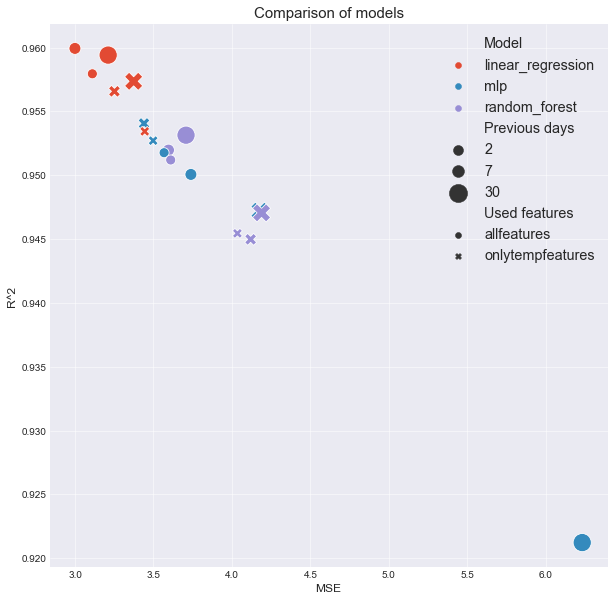

In [162]:
results_without_wind = results[results['Used features'] != 'wind']

sns.set_style(style='darkgrid')
figure, ax = plt.subplots(figsize=(10,10))
ax.set_title('Comparison of models')
sns.scatterplot(data=results_without_wind, x='MSE', y='R^2', hue='Model', size='Previous days', sizes=(100, 330), style='Used features', ax=ax)
plt.legend(fontsize='x-large')

# Linear regression

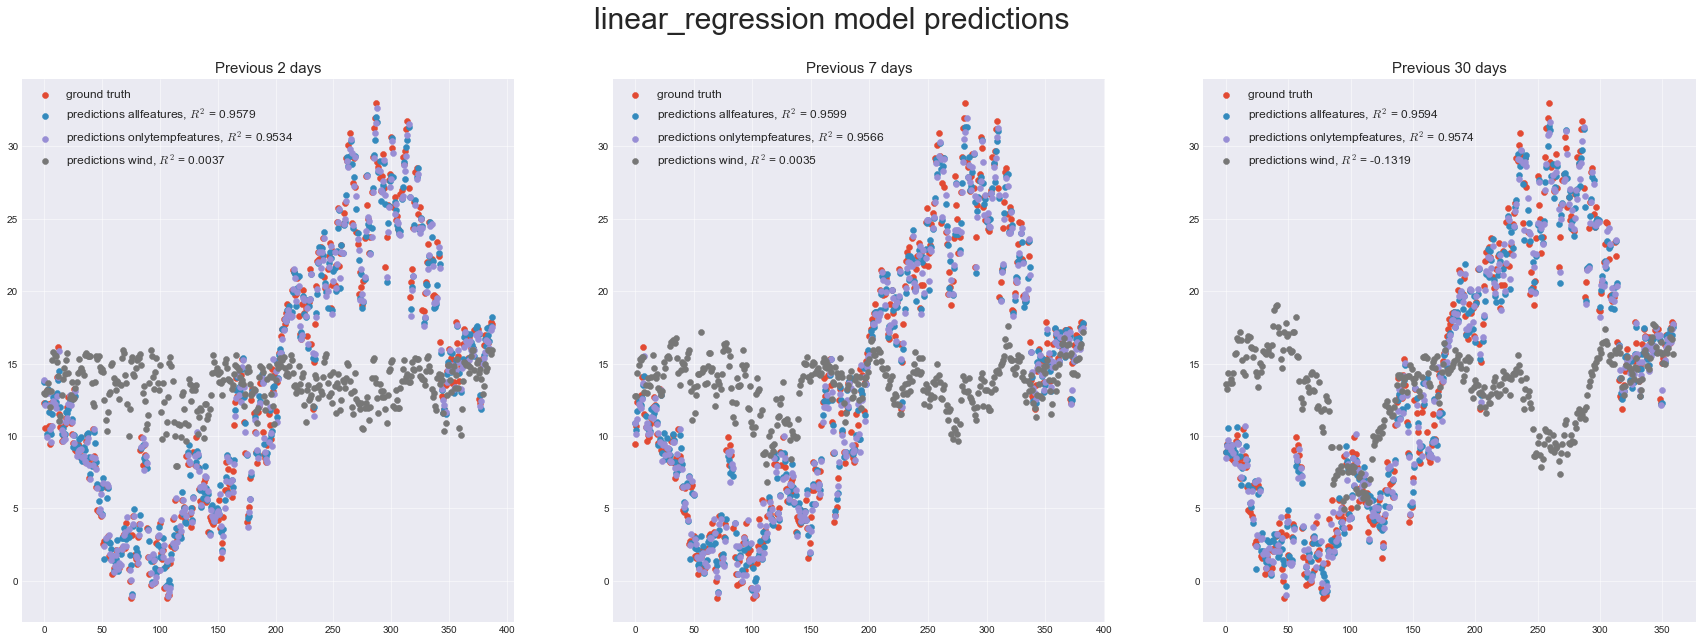

In [163]:
show_predictions('linear_regression')

# Random forest

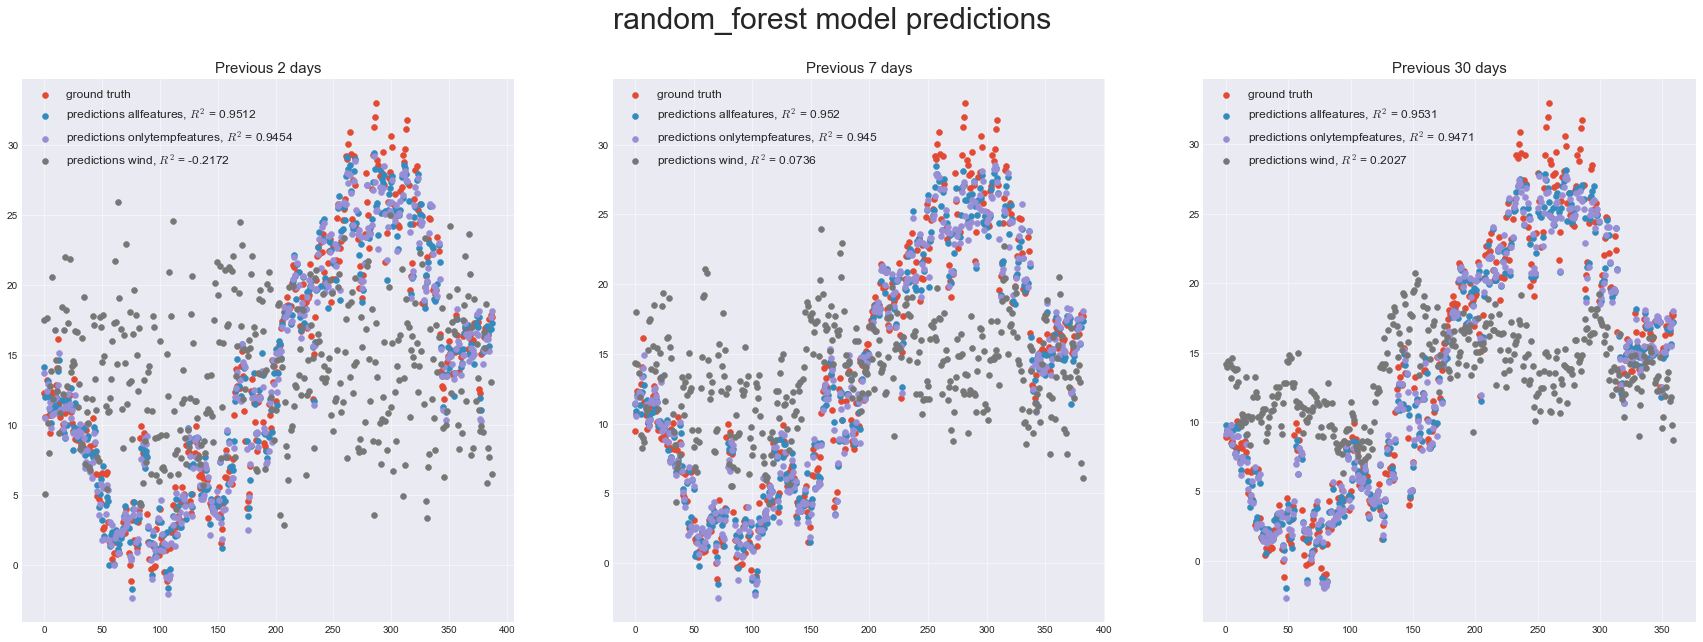

In [164]:
show_predictions('random_forest')

# Multilayer perceptron

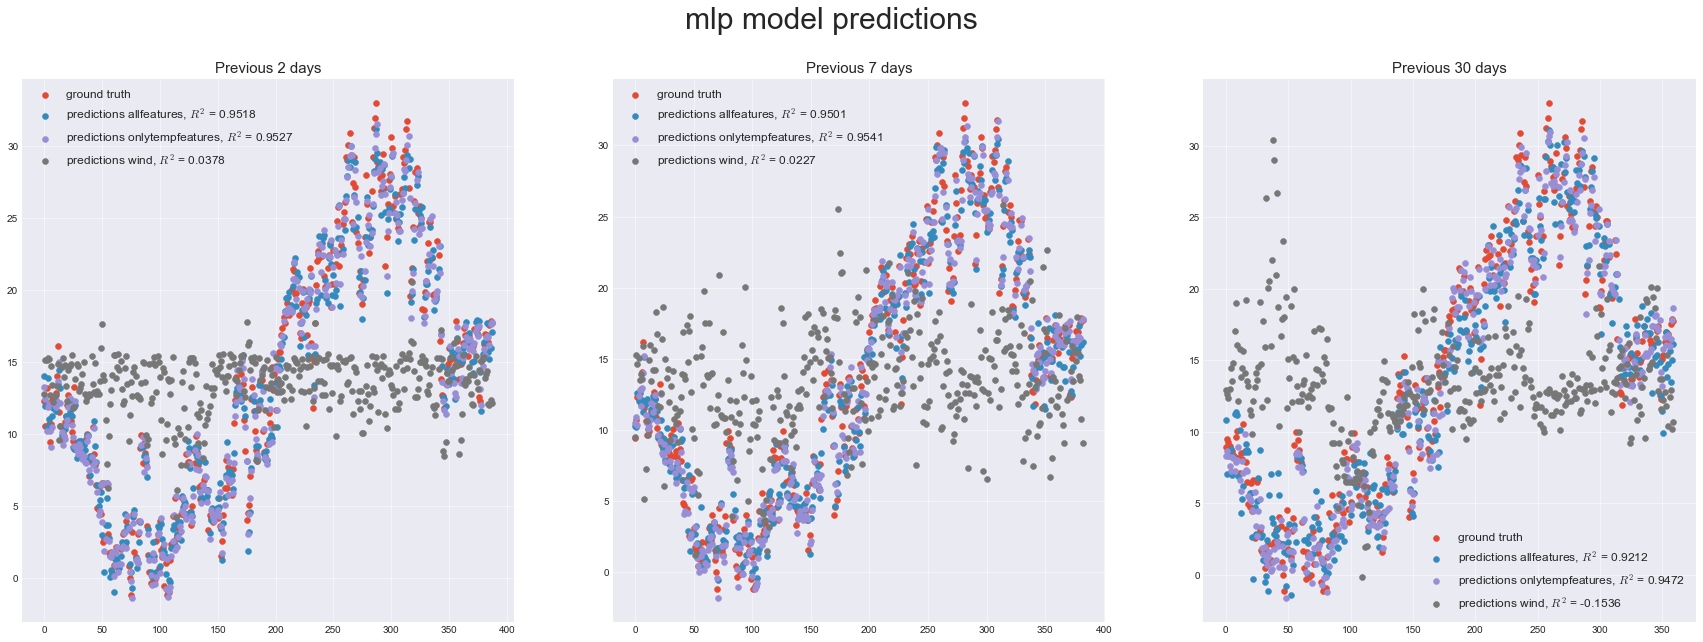

In [165]:
show_predictions('mlp')